In [10]:
import numpy as np
import qutip as qt
import scipy as sc
import scipy.signal as scs
import physical_constants as pc
import matplotlib as mpl
import matplotlib.colors as cl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pickle
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work

# Progress bar yay
from ipywidgets import FloatProgress

## Non-Tuneable Device Spectrum

Check the energy spectrum against Z flux and the multiphoton gaps.

In [2]:
#
#   CSFQ Hamiltonian without BO approximation and negligible inductance.
#
def Hcsfq_nL(phi_x,phi_z,Jc,Ca,Ajj,alpha,Csh,asy=0.0,Qms=None,Qps=None,Dt=None,Dms=None,Dps=None):

    # Asymmetry factor and phase
    asy_f = np.sqrt(1 + asy**2 * np.tan(phi_x/2)**2)
    asy_p = np.arctan(asy * np.tan(phi_x/2))
    
    # Slow charging energy (GHz)
    Em = 2*pc.e**2/((2*Csh + (2*alpha+1)*Ajj*Ca*1e-15)*pc.hbar) * 1e-9
    
    # Fast charging energy (GHz)
    Ep = 2*pc.e**2/(Ajj*Ca*1e-15*pc.hbar) * 1e-9
    
    # Josephson energy (GHz)
    Ej = Ajj*Jc*pc.phi0/(2*np.pi*pc.hbar) * 1e-15
    
    # Construct Hamiltonian
    H = 0.5*Em*Qms + 0.5*Ep*Qps - 0.5*Ej*Dt + asy_f*0.5*alpha*Ej*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*Dps+np.exp(-1j*(phi_z-asy_p))*Dms)
    
    # Return relevant parts
    return H.data.todense()

In [15]:
# Define some reasonable parameters
Jc = 3 # uA/um^2
Ca = 60 # fF/um^2
Ajj = 0.31*0.15 # um^2
alpha = 0.41
Csh = 55e-15 # F
asy = 0.0

#
# Create the operators for non-BO CSFQ
#

# Two Hilbert space truncators
truncm = 80
truncp = 10

# Charge operators
Qm = qt.num(truncm,-(truncm - 1)/2)
Qp = qt.num(truncp,-(truncp - 1)/2)

# Slow charge raising operator
Dm_p = qt.qeye(truncm) - qt.qeye(truncm)
for i in range(truncm-1):
    Dm_p += qt.basis(truncm,i)*qt.basis(truncm,i+1).dag()

# Slow charge lowering operator
Dm_m = Dm_p.dag()

# Fast charge raising operator
Dp_p = qt.qeye(truncp) - qt.qeye(truncp)
for i in range(truncp-1):
    Dp_p += qt.basis(truncp,i)*qt.basis(truncp,i+1).dag()

# Fast charge lowering operator
Dp_m = Dp_p.dag()

# Construct the operators in the extended Hilbert space
Qms = qt.tensor(Qm**2,qt.qeye(truncp))
Qps = qt.tensor(qt.qeye(truncm),Qp**2)
Dt = qt.tensor(Dm_p,Dp_p) + qt.tensor(Dm_m,Dp_m) + qt.tensor(Dm_m,Dp_p) + qt.tensor(Dm_p,Dp_m)
Dms = qt.tensor(Dm_m**2,qt.qeye(truncp))
Dps = qt.tensor(Dm_p**2,qt.qeye(truncp))

In [16]:
# Gen data sets: non-BO
phiz = np.linspace(-0.2*np.pi,0.2*np.pi,201)
Ez2 = [0.0]*201
for i,z in enumerate(phiz):
    E = np.linalg.eigvalsh(Hcsfq_nL(0.0,z,Jc,Ca,Ajj,alpha,Csh,asy=asy,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    Ez2[i] = E-E[0]
Ez2 = np.array(Ez2)

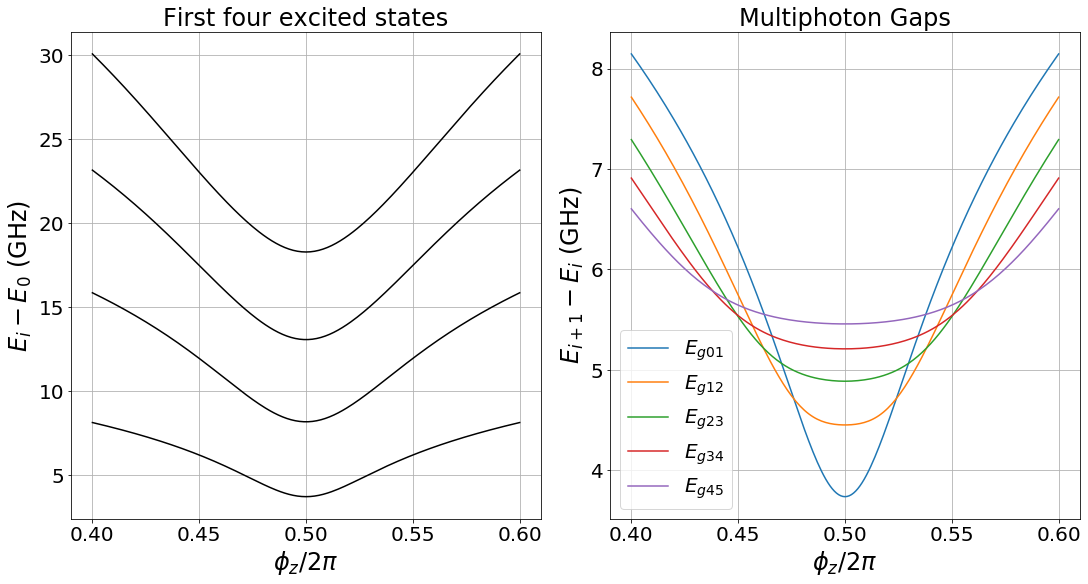

In [17]:
# Get figure and axis object
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=(15,8)) # WARNING! Experimental Feature that may break in the future
ax1 = ax[0]
ax2 = ax[1]

# Z dependence
for i in range(4):
    ax1.plot(phiz/(np.pi*2)+0.5, Ez2[:,2*i+2]/(2*np.pi),"k-")
ax1.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax1.set_ylabel('$E_i-E_0$ (GHz)',fontsize="large")
ax1.grid()
ax1.set_title("First four excited states")

# X dependence
ax2.plot(phiz/(np.pi*2)+0.5, (Ez2[:,2])/(2*np.pi),label="$E_{g%i%i}$"%(0,1))
for i in range(4):
    ax2.plot(phiz/(np.pi*2)+0.5, (Ez2[:,2*i+4]-Ez2[:,2*i+2])/(2*np.pi),label="$E_{g%i%i}$"%(i+1,i+2))
ax2.set_xlabel('$\phi_z/2\pi$',fontsize="large")
ax2.set_ylabel('$E_{i+1}-E_{i}$ (GHz)',fontsize="large")
ax2.grid()
ax2.set_title("Multiphoton Gaps")
ax2.legend()

# Save
plt.show()
plt.close()

## Resonator Shifts Under Qubit Excitation

Check the amplitude of the resonator dispersive shift under different excitations.

In [19]:
#
#  Jaynes-Cumming RWA strip diagonaliser, adapted from Mostafa's code
#
def diagonalize_ladder(nmax, omega_r, qubit_energy_list, g_list):
    
    # Maximum number of transmon levels, which also sets the size of the RWA
    # strip
    tmax = len(qubit_energy_list)
    
    # The order that should be used to sort the eigenenergies
    order = np.zeros(tmax,dtype=np.int)

    # Bare energies of the system
    diag_bare = np.array([-i*omega_r + qubit_energy_list[i]
                          for i in range(tmax)])
    # Eigenenergies in the order produced by diagonalizer
    eigensolver_order = np.linalg.eigvalsh(np.diag(diag_bare))

    # Find where the diagonalizer puts the energies
    for i in range(tmax):
        index, = np.where(eigensolver_order==diag_bare[i])
        order[i] = index
    
    # Initialise
    eigen_energies = [0.0]*nmax
    diagonal_elements = None
    offdiagonal_elements = None
    strip_H = None
    e = None
    
    # Get the eigenenergies of the whole ladder
    for n in range(nmax):
        
        # Diagonal elements of the RWA strip Hamiltonian
        diagonal_elements = np.array([(n-i)*omega_r + qubit_energy_list[i] for i in range(tmax)])
        
        # Off-diagonal elements of the RWA strip Hamiltonian
        offdiagonal_elements = np.array([g_list[i]*np.sqrt((n-i)*(n-i>0)) for i in range(tmax-1)])
        
        # Construct the total Hamiltonian of the RWA strip
        strip_H = (np.diag(diagonal_elements) + np.diag(offdiagonal_elements, 1) +
                   np.diag(offdiagonal_elements, -1))

        # Get eigensystem
        e = sc.linalg.eigvalsh(strip_H)
        
        # Sort eigenvalues and vectors
        eigen_energies[n] = np.array([e[i].real for i in order])
    
    return eigen_energies

#
#  Get the resonator response for a given qubit/resonator state
#
def resonator_response(x,z,params,k,n):
    g0 = params["g0"]
    asy = params["asy"]
    wr = params["wr"]
    Ajj = params["Ajj"]
    Csh = params["Csh"]
    alpha = params["alpha"]
    Jc = params["Jc"]
    Ca = params["Ca"]
    truncm = params["truncm"]
    truncp = params["truncp"]
    nmax = int(params["nmax"])
    
    # Get Hamiltonian
    E,psi = np.linalg.eigh(Hcsfq_nL(0.0,z,Jc,Ca,Ajj,alpha,Csh,asy=asy,Qms=Qms,Qps=Qps,Dt=Dt,Dms=Dms,Dps=Dps))
    
    # Convert all the eigenvectors to Qobj (need to change this asap)
    psi = [qt.Qobj(psi[:,j],isherm=False) for j in range(truncm*truncp)]
    
    # Shunt cap charge node
    Q = qt.tensor(Qm,qt.qeye(truncp)) + qt.tensor(qt.qeye(truncm),Qp)
    
    norm = (psii1[0].dag()*Q*psii2[1])[0][0][0]

In [ ]:
params = {
    "g0":
}
resonator_response()